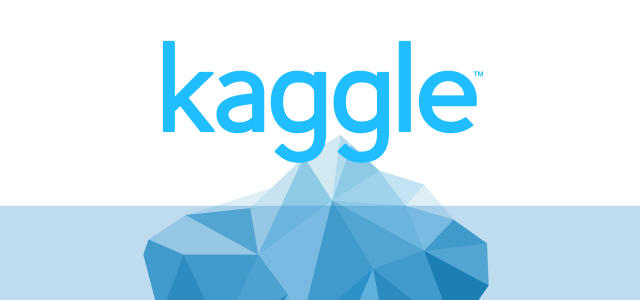

As a student or an aspiring data scientist, looking for a topic to tackle can be a bit challenging,
especially since most kernels do not get the attention, upvotes, or views they deserve.

In this kernel, we will analyse the meta data behind that might boost the popularity of a Kaggle kernels.

The work will be focusing on logical and practical sides, we analyse the features that might influence people into clicking to open the kernel page.

We will also analyse the title data through NLP and in the end, we try to train a classifier for attractive titles.




This analysis will focus on those points:

* Is it better to write the kernel using Python or R?  
* Is it better to make it a notebook or a script?     
* Publication date (time series analysis) 
* Views - votes - coments correlation and association
* Do more experienced users have more appeal? 
* What are the most important tags? 
* Is it better to keep updating the kernel?


* Does the title matter? (NLP analysis, classification and application)

The visualizations will be done interactively with plotly, however, as plotly might get slow and consuming, we will use the regular plotting libraries for more general plotting.

# 0. Data exploration

#### Importing libraries and data

In [ ]:
import numpy as np
import pandas as pd
#basic data science libraries for data manipulation

import warnings #Used to hide unnecessary warning messages

warnings.simplefilter('ignore')



import matplotlib.pyplot as plt 
import seaborn as sns 
#plotting libraries
sns.set(style='darkgrid', palette='Set3')



import plotly as py 
from plotly import subplots
from plotly.offline import init_notebook_mode, plot, iplot
import plotly.graph_objects as go  
#for interactive plotting
init_notebook_mode(connected=True)
py.offline.init_notebook_mode (connected = True)




from wordcloud import WordCloud
import nltk
import string
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
import random
import statistics
from nltk.classify import NaiveBayesClassifier
#text data manipulation, visualization and classification




from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.layers import SpatialDropout1D
from keras.layers.recurrent import LSTM, GRU
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.embeddings import Embedding
from keras.layers.normalization import BatchNormalization
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import EarlyStopping
#deep learning libraries for further application



In [ ]:
languages=pd.read_csv('/kaggle/input/meta-kaggle/KernelLanguages.csv')
kernels=pd.read_csv('/kaggle/input/meta-kaggle/Kernels.csv')
kernelTags=pd.read_csv('/kaggle/input/meta-kaggle/KernelTags.csv')
tags=pd.read_csv('/kaggle/input/meta-kaggle/Tags.csv')
versions=pd.read_csv('/kaggle/input/meta-kaggle/KernelVersions.csv')

#### Getting familiar with data and reducing it

In [ ]:
languages.tail()

In [ ]:
languages= languages[['Id','DisplayName','IsNotebook']]

Languages dataset contains the coding language and notebook options, these are important features but has to mapped into the main dataset.

In [ ]:
kernels.tail()

In [ ]:
kernels=kernels[['Id','CurrentKernelVersionId','FirstKernelVersionId',
                'MadePublicDate','Medal','TotalViews','TotalComments','TotalVotes']]


Has valuable data : Medals, Votes, Date, Views
And has a lot of feihua data to clean

Data to add : Language (R/Python)
              Style (Script/Notebook)
              Tags
              
Data to handle : Clean normal process (missing data, features engineering, types, distributions)
                 Text data manipulation (Create title case and manipulate) 
                

In [ ]:
kernelTags.tail()

This dataset will act as an intermediate to map the tags used

In [ ]:
tags.tail()

In [ ]:
tags=tags[['Id','Name']]

Gotta join tags tab and tags Ids to later join them with main tab data

In [ ]:
versions.tail()

In [ ]:
versions= versions[['ScriptId','ScriptLanguageId','AuthorUserId','VersionNumber','Title']]

This dataset has the required data to map different values and also sum up the kernels into their final version form.

# 1. Data wrangling

Our data is numerous, diverse ,repetitive and divided into 5 dataframes, in this part, we will gather the most valuable data into one main dataframe that will be used for the analysis.

In [ ]:
#Starting by merging the data

versions.drop_duplicates(subset='ScriptId',keep='last',inplace=True)

versions =versions.join(languages.set_index('Id'), on='ScriptLanguageId', how='left')

kernels =versions.join(kernels.set_index('Id'), on='ScriptId')

kernelTags= kernelTags.join(tags.set_index('Id'),on='TagId', how='left')



In [ ]:
#Stacking the Tags into rows and merging into a main dataframe

a=kernelTags[kernelTags.duplicated('KernelId')] [['KernelId','Name']]
c=kernelTags.drop_duplicates(subset='KernelId', keep='first').join(a.set_index('KernelId'),on='KernelId', how='left',rsuffix='_2')

a=c[c.duplicated('KernelId')] [['KernelId','Name_2']]
d=c.drop_duplicates(subset='KernelId', keep='first').join(a.set_index('KernelId'),on='KernelId', how='left',rsuffix='_3')

a=d[d.duplicated('KernelId')] [['KernelId','Name_2_3']]
e=d.drop_duplicates(subset='KernelId', keep='first').join(a.set_index('KernelId'),on='KernelId', how='left',rsuffix='_4')

a=e[e.duplicated('KernelId')] [['KernelId','Name_2_3_4']]
f=e.drop_duplicates(subset='KernelId', keep='first').join(a.set_index('KernelId'),on='KernelId', how='left',rsuffix='_5')

tags=f.drop_duplicates('KernelId',keep='first')
Names={'Name':'Tag1','Name_2':'Tag2','Name_2_3': 'Tag3','Name_2_3_4':'Tag4','Name_2_3_4_5':'Tag5'}
tags.rename(Names, axis=1, inplace=True)
tags.drop(columns=['TagId','Id'],inplace=True)

In [ ]:
kernels =kernels.join(tags.set_index('KernelId'), on='ScriptId', how='left')
kernels.drop(columns=['ScriptLanguageId','CurrentKernelVersionId','FirstKernelVersionId'],inplace=True)
kernels.tail()

We end up with a main dataframe with 15 columns resuming our data in a very clear way and carrying the most noticeable or valuable data. <br>
We will be using copies of this dataframe for most analysis, however, we might need another dataframe at some point.

# 2. Cleaning

In this section we deal with
* Missind data
* Illogical data 
* Outliers


In [ ]:
# We only take in consideration published works
kernels.dropna(axis=0,subset=['MadePublicDate'], inplace=True)

# we fill the missing data in Versions with 1 
kernels.loc[kernels['VersionNumber'].isna()].fillna(1, inplace=True)

# we fill the missing data in language with other and in Isnotbook as False
kernels['DisplayName'].fillna('Other', inplace=True)
kernels['IsNotebook'].fillna(False,inplace=True)

* We only take in consideration published works as the end goal is to evaluate the popularity of kernels.
* The kernels left are all published, so they have at least 1 version, we fill the missing data in Versions with 1 as the first version.
* We notice some kernels do not have a Language, after checking some example, we find that there are other languages used that kaggle does not classify. Example:

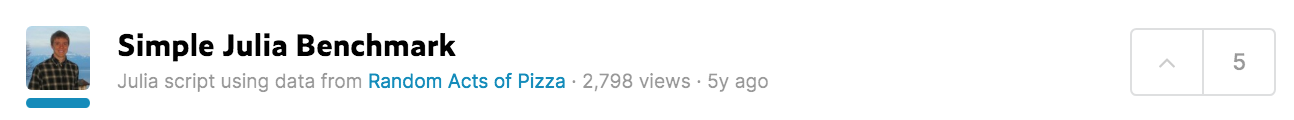

* Those languages are naturally not adapted to Notebooks, so we fill the Notebook missing values with False.

In [ ]:
print(kernels['Medal'].isna().count())

The medal feature does not make sense (93% missing data), so we drop it.

In [ ]:
kernels.drop('Medal',axis=1,inplace=True)
kernels.reset_index(drop=True,inplace=True)
kernels.head()

This is the last version of our main dataframe, clean and ready to use.

# 3. Analysis and visualizations

We try to define some patterns and then see how some features influence the popularity of a kernel (views, votes and comments)

## Languages

In [ ]:
label=['notebook','script']
trace1=go.Pie(labels=kernels['DisplayName'],domain=dict(x=[0, 0.5]),name='Language',marker_colors=['#ADFFA2','darkred'])
trace2=go.Pie(labels=kernels['IsNotebook'], domain=dict(x=[0.5, 1.0]), name='Notebook', marker_colors=['#6ED1E9','grey'])

fig1 = subplots.make_subplots(rows = 1, cols = 2, specs=[[{"type": "pie"}, {"type": "pie"}]])
fig1.add_trace(trace1,row=1,col=1)
fig1.add_trace(trace2,row=1,col=2)

fig1.update_traces(hoverinfo='label+percent+name', textinfo='label',textfont_size=20,marker=dict(line=dict(color='#000000', width=2)))
fig1.update(layout_title_text='Language and notebook types',layout_showlegend=False)

iplot(fig1)

In [ ]:
languagePlot= kernels.groupby('DisplayName').sum().reset_index()
notebookPlot= kernels.groupby('IsNotebook').sum().reset_index()

languageCount= kernels.groupby('DisplayName').count().reset_index()
notebookCount= kernels.groupby('IsNotebook').count().reset_index()

trace3= go.Bar(x=languagePlot['DisplayName'],y=languagePlot['TotalVotes']/languageCount['TotalVotes'], name='Votes',marker_color='lightgreen')
trace4= go.Bar(x=languagePlot['DisplayName'],y=languagePlot['TotalComments']/languageCount['TotalComments'], name ='Comments')

trace5= go.Bar(x=notebookPlot['IsNotebook'],y=notebookPlot['TotalVotes']/notebookCount['TotalVotes'], name='Votes',marker_color='#FF9700')
trace6= go.Bar(x=notebookPlot['IsNotebook'],y=notebookPlot['TotalComments']/notebookCount['TotalComments'], name ='Comments',marker_color='purple')
fig2= subplots.make_subplots(rows= 1 , cols = 2)

fig2.append_trace(trace3,row=1,col=1)
fig2.append_trace(trace4,row=1,col=1)
fig2.append_trace(trace5,row=1,col=2)
fig2.append_trace(trace6,row=1,col=2)

fig2.update(layout_title_text='Average popularity of languages',layout_showlegend=False)
fig2.update_traces(marker=dict(line=dict(color='#000000', width=2)))
fig2.update_yaxes(showticklabels=False)

iplot(fig2)

* Python is used in 90% of the kernels, showing a large domination.
* Notebooks are only used in 42% of the cases.
* Python and R have almost the same average votes and comments, tiny advantage for Python.
* The R kernels have in average more comments than Python.
* Other languages do not get as much importance as the main 2.
* Scripts have almost twice the popularity of Notebooks, (97% more votes and 91% more comments)
* Writing in a script is likely to get you twice votes and coments as notebook.


## Author Users

In [ ]:
kernels['AuthorUserId']= kernels['AuthorUserId'].astype(str)

authorPlot=kernels.groupby(by=kernels['AuthorUserId']).count().reset_index()
authorPlot.sort_values(by='Title', ascending=False,inplace=True)


authorPlot['Title'].head()
authorPlot= authorPlot[1:]
print('Average number of kernels per user:',authorPlot['Title'].mean())


In [ ]:
authorPlot= authorPlot[:30]


f=plt.subplots(figsize=(18,8))
f=sns.barplot(x=authorPlot['AuthorUserId'],y=authorPlot['Title'],color='orange')
f.set_title('Number of lernels by most active users')
f.set_xticklabels(f.get_xticklabels(), rotation=45)
a=f.set(xlabel='User Id', ylabel='Number of Kernels')

In [ ]:
authorPlot=kernels.groupby(by=kernels['AuthorUserId']).sum().reset_index()
authorPlot.sort_values(by='TotalVotes', ascending=False,inplace=True)
authorPlot= authorPlot[:30]

f=plt.subplots(figsize=(18,8))
f=sns.barplot(x=authorPlot['AuthorUserId'],y=authorPlot['TotalVotes'],color='orange')
f.set_title('Number of votes by users')
f.set_xticklabels(f.get_xticklabels(), rotation=45)
a=f.set(xlabel='User Id', ylabel='Number of votes')

* We have a clear value that is an outlier and does not represent the rest of data, so we take it off
* In average, users creates and publishes 2 kernels, however, some users are more active than others

* There are nevertheless many users with over a 100 different published kernels.

* 2603295, 1162990, 505747, 495305, 417337 appear in both graphs, it logically yields the most kernels a User publishes, the more votes he would get, however, it's not always true as 25/30 did not appear in both lists.

## Dates

In [ ]:
kernels['MadePublicDate']=pd.to_datetime(kernels['MadePublicDate'])
dates=kernels.groupby(kernels['MadePublicDate']).count().reset_index()

trace7=go.Line(y=dates['Title'],x=dates['MadePublicDate'], name='Published kernels')
trace8=go.Line(y=dates['Title'][-425:-365],x=dates['MadePublicDate'][-425:-365],name='Published kernels')

fig3 = subplots.make_subplots(rows = 2, cols = 1)
fig3.add_trace(trace7,row=1,col=1)
fig3.add_trace(trace8,row=2,col=1)

fig3.update(layout_title_text='Trends with a zoom on a month in 2019',layout_showlegend=False)
iplot(fig3)

In [ ]:
#we use regular plotting here as the y axis is not important since we're doing a 6 months rolling mean to see the evolution
plt.figure(figsize=(20,6))
plt.plot(dates['MadePublicDate'],dates['Title'].rolling(180).mean(),linewidth=3, c='black')
a=plt.title('6 months rolled mean analysis of the Number of published kernels ')

* Notice the trend gets the lowest on the 1, 8, 15, 21, 29 of September 2019... Those are sundays, Users tend to publish less on Sundays.
* There is no noticeable seasonality on a higher scale, but we notice an evolution.
* With the 6 months rolling mean, we notice that Kaggle was growing so fast until 2017 where it dropped suddenly.
* Kaggle notoriety started growing again and recorded a tremendous grow during the 2020 pandemic period (March 2020)

In [ ]:
trace9=go.Line(y=dates['TotalViews'],x=dates['MadePublicDate'],name='Views')
trace10=go.Line(y=dates['TotalVotes'],x=dates['MadePublicDate'],name='Votes')
trace11=go.Line(y=dates['TotalComments'],x=dates['MadePublicDate'], name='Comments')


fig4 = subplots.make_subplots(rows = 3, cols = 1)
fig4.add_trace(trace9,row=1,col=1)
fig4.add_trace(trace10,row=2,col=1)
fig4.add_trace(trace11,row=3,col=1)

fig4.update(layout_title_text='Views, votes and comments over time',layout_showlegend=False)
iplot(fig4)

In [ ]:
#as we did earlier, 6 months roll are represented in basic plotting
dates=kernels.groupby(['MadePublicDate']).sum().reset_index()
f=plt.figure(figsize=(20,10))
ax1=f.add_subplot(2,1,1)
ax1.plot(dates['MadePublicDate'],dates['TotalViews'].rolling(180).mean(),label='Views', linewidth=3, c= 'blue')
ax1.set_title('6 months rolled mean analysis of the Views of published kernels ')
ax1.legend()

ax2=f.add_subplot(2,1,2)
ax2.plot(dates['MadePublicDate'],dates['TotalVotes'].rolling(180).mean(),label='Votes', linewidth=3, c= 'red')
ax2.plot(dates['MadePublicDate'],dates['TotalComments'].rolling(180).mean(), label='Comments', linewidth=3, c= 'green')
ax2.legend()
a=ax2.set_title('6 months rolled mean analysis of the Votes and comments of published kernels ')

* As the number of published kernels, the votes, views and comments follow the same trends.
* These last 6 months (April-October 2020) are the best time to publish a kernel, as the number of comments and votes is reaching its maximum so far.
* In April October 2020, there are 60% more votes in average than 2018-2020 period.

## Votes Views Comments

In [ ]:
percentageVotes=kernels['TotalVotes'].sum()/kernels['TotalViews'].sum() * 100
percentageComments=kernels['TotalComments'].sum()/kernels['TotalViews'].sum() * 100

print(float("{0:.4f}".format(percentageVotes)),'%   votes/views')
print(float("{0:.4f}".format(percentageComments)),'%   comments/views')


correlations=kernels[['TotalViews','TotalVotes','TotalComments']]

f=plt.figure(figsize=(10,8))
f=sns.heatmap(correlations.corr(),annot=True)
a=f.set_title('Matrix of correlation')

In other words, in average, a vote comes from 163 views, and a comment comes from 704 views.

## Version number

In [ ]:
versionsPlot=kernels
versionsPlot = kernels[kernels['VersionNumber'] < kernels['VersionNumber'].quantile(0.9999)]
versionsPlot = versionsPlot[kernels['TotalVotes'] < versionsPlot['TotalVotes'].quantile(0.9999)]



trace12=go.Scattergl(x=versionsPlot['VersionNumber'],y=versionsPlot['TotalVotes'], mode='markers', name='Votes', marker_color='#3C8E6A')
trace13=go.Scattergl(x=versionsPlot['VersionNumber'],y=versionsPlot['TotalComments'], mode='markers', name='Comments',marker_color='#893636')
# an hex plot might have been clearer
fig5= go.Figure()
fig5.add_trace(trace12)
fig5.add_trace(trace13)
fig5.update_layout(title='Distribution of votes/comments by version number')
fig5.update_xaxes(title_text='Version')
fig5.update_traces(marker=dict(line=dict(color='#000000', width=0.5)))


iplot(fig5)

* Most of the upvoted and commented kernels have a version superior than 1, this means that coreccting, improving or modifying kernels is a thing that helps kernel stay on the first page and brings more viewers, votes and comments.
* On the other hand, a lot of version does necessarily imply more votes or comments.

## Tags

In [ ]:
tagsPlot= kernelTags.groupby(['Name']).count().reset_index()
tagsPlot.sort_values(by='KernelId',ascending=False, inplace=True)
tagsPlot=tagsPlot.head(12)


plt.figure(figsize=(20,7))
f=sns.barplot(x=tagsPlot['Name'],y=tagsPlot['KernelId'])
f.set_title('Most used tags')
f.set_xlabel('Tag')
a=f.set_xticklabels(f.get_xticklabels(), rotation=15)

In [ ]:
kernelTags =kernels.join(kernelTags.set_index('KernelId'), on='ScriptId', how='left')
kernelTags= kernelTags[['ScriptId','TotalVotes','Name']]

tagsPlot= kernelTags.groupby(['Name']).sum().reset_index()
tagsPlot.sort_values(by='TotalVotes',ascending=False, inplace=True)
tagsPlot=tagsPlot.head(12)


plt.figure(figsize=(20,7))
f=sns.barplot(x=tagsPlot['Name'],y=tagsPlot['TotalVotes'])
f.set_title('Tags attracting most votes')
f.set_xlabel('Tag')
a=f.set_xticklabels(f.get_xticklabels(), rotation=15)

* 'gpu' is the most used tag as it is automatically enabled if gpu is used in kernel. (over 45k kernels)
* 'beginner' is the second most used tag, it also is the tag attracting most people in Kaggle.
* Data science basics tags are also a good way to attract people as they rank very high, examples: 'data visualization, exploratory data analysis, featureenginnering and data cleaning
* There are also some Machine learning and Deep learning tagged kernels who get attention, examples: ' Classification, deep learning, learn, nlp, cnn, xgboost'
* We conclude that the most visited kernels are the tutorials, guides and beginner kernels.

## Value of words

First, data have to be cleaned from stopwords, punctuation and other noise data

In [ ]:
kernels.reset_index(drop=True, inplace=True)
kernels['Title']= kernels['Title'].astype(str)

kernels['Title'].replace('_', ' ', inplace=True)
kernels['Title'].replace('.', ' ', inplace=True)

more=[' ',"'s","''","``",'-','_','‘’',',']
stop= set(stopwords.words('english')+list(string.punctuation)+more)


In [ ]:
words=list()
for i in range(0,len(kernels)):
    for w in word_tokenize(kernels['Title'][i]):
        if w.lower() not in stop:
            words.append(w.lower())
            
frequent=pd.DataFrame(pd.Series(nltk.FreqDist(words)))
frequent.reset_index(inplace=True)
frequent.sort_values(by=(0),ascending=False, inplace= True)

f,ax=plt.subplots(figsize=(20,8))
f=sns.barplot(frequent['index'][:12],frequent[0][:12])
a=ax.set(title='Barplot of the most used words',xlabel='Words', ylabel='')

In [ ]:
#wordcloud
wordcloud = WordCloud(background_color = 'white',width=2000, height=900, max_words = 100).generate(' '.join(kernels['Title']))
f,ax=plt.subplots(figsize = (200, 120) ) 
plt.imshow(wordcloud) 
a=plt.axis('off')

# 4. Text classification

## Classification

* In order for our model to make sense, we divide our data into 2 bins, a bin with 0 votes and a bin with at least 1 vote.
* Then we sample the data as we have more than 390k row and that is practically useless for most models.
* We take the last 100k entries as the old data can be outdated misleading.
* We sample 15k for our Naive Bayes classiier model.

In [ ]:
kernelsBins=kernels.copy()
bins=[-1,0,100000]
labels=['1','2']
kernelsBins['TotalVotes']= pd.cut(kernelsBins["TotalVotes"], bins , labels=labels)

#We only take the most recent 100k as the old data might be misleading and/or out of date
recentKernels=kernelsBins[-100000:].copy()


#Sampling 15k data with same distribution as the population
sampleML=kernelsBins[320000:335000]
sampleML.reset_index(inplace=True, drop=True)

#Displaying the percentage
sampPercent=sampleML.loc[sampleML['TotalVotes']=='2'].count() [1]/sampleML['TotalVotes'].count() 
fullPercent=recentKernels.loc[recentKernels['TotalVotes']=='2'].count() [1] /recentKernels['TotalVotes'].count() 

print('General percentage' ,fullPercent*100,'%')
print('Percentage of the sample',sampPercent*100,'%')


In [ ]:
#extracting the word frequence distribution to create features later on
words=list()
for i in range(0,len(sampleML)):
    for w in word_tokenize(sampleML['Title'][i]):
        if w.lower() not in stop:
            words.append(w.lower())
            
freq=list(dict(sorted(nltk.FreqDist(words).items(), key=lambda item: item[1], reverse=True)))[:5000]

#a function to find the features from the words
def find_feat(text):
    word=set(text)
    features={}
    for w in freq:
        features[w]=(w in word)
    return features

#a function to clean the data from stopwords after tokenizing
def clean(text):
    l=list()
    for w in word_tokenize(text):
        if w.lower() not in stop:
            l.append(w.lower())
    return l
            


In [ ]:
# preprocessing, extracting features and splitting the data into train/test 
documents=list()
for i in range(0,len(sampleML)):
     documents.append([clean(sampleML['Title'][i]), sampleML['TotalVotes'][i]])

doc=list()
for i in range(0,len(sampleML)):
    for w in clean(sampleML['Title'][i]):
        doc.append((w.lower()))
ratio=int(len(doc)/15)

random.shuffle(documents)
featuresets = [(find_feat(title), votes) for (title, votes) in documents]
random.shuffle(featuresets)

split=int(len(featuresets)-len(featuresets)/5)
train=featuresets[:split]
test=featuresets[split:]



In [ ]:
clf_naiveBayes=nltk.NaiveBayesClassifier.train(train)
print("Classifier accuracy percent:",(nltk.classify.accuracy(clf_naiveBayes, test))*100)

In [ ]:
clf_naiveBayes.show_most_informative_features(20)

* NaiveBayes gives a rough idea about the words values.
* The second column represents the bin the word is most likely to belong to (2: 1 vote or more, 1:0 votes).
* The third column is the probablity of the prediction.
* Naive Bayes classifier is unstable and another execution of the same code mighr give different outcome, but the results are reliable.
* Notice how the word "Visualization" is more liked as "visualisation". (this might not appear in all executions)

# 5. NLP Deep learning application

After seeing that, we try a more pratical application using some neural network to train a deep learning model and apply it to predict a good title for this kernel.

In [ ]:
#we use 100k data 
#we clean and prepare data before using it
recentKernels.reset_index(drop=True,inplace=True)
for i in range (0,len(recentKernels)):
    recentKernels['Title'][i]=clean(recentKernels['Title'][i])
for i in range (0,len(recentKernels)):
    space=' '
    recentKernels['Title'][i]=space.join(recentKernels['Title'][i])



max_features = 5000
tokenizer = Tokenizer(nb_words=max_features, split=' ')
tokenizer.fit_on_texts(recentKernels['Title'].values)
X = tokenizer.texts_to_sequences(recentKernels['Title'].values)
X = pad_sequences(X, maxlen=15)
Y = pd.get_dummies(recentKernels['TotalVotes']).values
x_train, x_test, y_train, y_test = train_test_split(X,Y, random_state = 42,shuffle=True)

print(x_train.shape,y_train.shape)

* We build an LSTM model and double gru layers model.
* We use a rather low number of neutrons as the data we have is not very expressive and a very deep or big model might be an overkill.

In [ ]:
#LSTM squential model
lstmModel = Sequential()
lstmModel.add(Embedding(max_features, 100,input_length=X.shape[1]))
lstmModel.add(SpatialDropout1D(0.4))

lstmModel.add(LSTM(100, dropout=0.3, recurrent_dropout=0.2))

lstmModel.add(Dense(2,activation='softmax'))
lstmModel.compile(loss='categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
#Using categorical_crossentropy for our classification problem

earlystop = EarlyStopping(monitor='val_loss', patience=5, verbose=0)
#Define an earlystop as our data does not carry an obvious pattern and might give our model a hard time learninf

print(lstmModel.summary())
history=lstmModel.fit(x_train, y_train, validation_split=0.1 ,batch_size=256, epochs=100, callbacks=[earlystop])

score,accu = lstmModel.evaluate(x_test, y_test, batch_size = 64)
print((accu)*100)

In [ ]:
f=plt.figure(figsize=(20,6))
plt.plot(history.history['accuracy'], label='train', c='green',linewidth=3)
plt.plot(history.history['val_accuracy'], label='test' , c='blue',linewidth=3)
plt.title('LSTM model Accuracy')
a=plt.legend()

In [ ]:
# GRU with glove embeddings and two dense layers
gruModel = Sequential()
gruModel.add(Embedding(max_features, 100,input_length=X.shape[1]))
gruModel.add(SpatialDropout1D(0.3))

gruModel.add(GRU(50,dropout=0.1, recurrent_dropout=0.2, return_sequences=True))
gruModel.add(GRU(100, dropout=0.1, recurrent_dropout=0.2))


gruModel.add(Dense(2,activation='softmax'))
gruModel.compile(loss='categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
#Using categorical_crossentropy for our classification problem

earlystop = EarlyStopping(monitor='val_loss', patience=5, verbose=0)
#Define an earlystop as our data does not carry an obvious pattern and might give our model a hard time learninf

print(gruModel.summary())
history=gruModel.fit(x_train, y_train, validation_split=0.1, batch_size=256, epochs=100, callbacks=[earlystop])

score,acc = gruModel.evaluate(x_test, y_test, batch_size = 64)
print((acc)*100)

In [ ]:
plt.figure(figsize=(20,6))
plt.plot(history.history['accuracy'], label='train', c='green',linewidth=3)
plt.plot(history.history['val_accuracy'], label='test' , c='blue',linewidth=3)
plt.title('gru model Accuracy')
a=plt.legend()

In [ ]:
newTitles=[['There is only one thing we say to death: Not today'],
          ['How to choose a topic and layout for a new Kaggle kernel'],
          ['Kaggle meta data analysis to boost your kernel exposure'],
          ['What is dead may never die'],
          ['Attracting Kaggle users - Using plotly visualisations and DL NLP predictions'],#Using the words from the NaiveBayes suggestions
          ['You know nothing, Jon Snow']] 

labels=['0 votes','1 vote or more']

print ('LSTM model')
for i in range (0,len(newTitles)):
    title=newTitles[i]
    sequence=tokenizer.texts_to_sequences(title)
    padded=pad_sequences(sequence, maxlen=15)
    prediction=lstmModel.predict(padded)
    print( title,'   ==>   ',labels[np.argmax(prediction)],'\n')
    
print ('\n \ngru model')
for i in range (0,len(newTitles)):
    title=newTitles[i]
    sequence=tokenizer.texts_to_sequences(title)
    padded=pad_sequences(sequence, maxlen=15)
    prediction=gruModel.predict(padded)
    print( title,' ==> ',labels[np.argmax(prediction)],'\n')


* All our models have around 70% accuracy.
* After all, our text data alone does not have a treshold or obvious or logical difference on the votes.
* The models have a tough time learning anything from data.
* However, a 70% accuracy is a rather good score for classification, and our example confirmed the good but not great job of our model.
* 'You know nothing, Jon Snow' got a False positive prediction, our model might like some Game of Thrones characters more than others.
* We use the title who had the unanimity between the 2 DL models and our previous ML model.


![](https://i.pinimg.com/originals/8d/e1/07/8de10711546dd4a1acbee5f2a2529da9.gif)